In [1]:
import gym

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from lcs.agents import EnvironmentAdapter
from lcs.metrics import population_metrics

# Logger
import logging
logging.basicConfig(level=logging.INFO)

# Research
The following notebook compares ACS2, AACS2, ACS2-AR agents on different multi-step environments. The main difference in agents behaviour is the _reinforcement learning_ module. The particular research is put on replacing the default discounted sum of rewards criterion with the averaged one. This is particulary true when the rewards received in all decisions instances are equally important.

The new variants of the ACS2 agent vary mainly in the definition of the _classifier reward_ $cl.r$ parameter.

All changes were made accordingly to those papers:
- "XCS with average reward criterion in multi-step environment" ~ Tharakunnel, Goldberg
- "Learning classifier system with average reward reinforcement learning" ~ Zang, Li, Wang, Xia

## Reinfocement Learning
Traditionally in ACS the classifiers reward $cl.r$ parameter is an estimate of discounted sum of successive rewards. Therefore the system is designed to address multistep problems with the objective of maximization of the total _discounted_ rewards.

However there are many real-world sequential decision problems where the prefered objective is the maximization of the _average_ of successive rewards. Example of such problems is when rewards received in all decision instances are equally important. In practice this criterion is especially useful in cases when decisions are made very frequently.

### Discounted (ACS2)
Classifiers reward $cl.r$ property is upaded after receiving current step reward $r$. 

$cl.r \leftarrow cl.r + \beta [R - cl.r ]$

where
$R = r + \gamma P^{max}_t$

and $\beta$ is the learning rate, $P^{max}_{t}$ denotes the maxiumum fitness from the match set $[M]$ from the current time step $t$

### Averaged-based (AACS2)

Similary as before the $cl.r$ is updated as:

$cl.r \leftarrow cl.r + \beta [R - cl.r ]$

but in this case the $R$ parameter is calculated but substracting the rho $\rho$ like

$R = r - \rho + \gamma P^{max}_t$

The $\rho$ parameter (estimated average reward) is updated only during **exploit** phase before all other updates:

$\rho \leftarrow \rho + \zeta (r - \rho)$

Typically the $\zeta$ average reward learning rate is set to a very low value. This ensures a nearly constant value of average reward for the update of the prediction, which is a necessary condition for the convergence of average reward RL algorithms.

#### R-learning variant (ACS2-AR)
It's another variant of the undiscounted reinforcement learning. It's idea is to maximize the average reward per time step.

The classifiers reward update is done as before:

$cl.r \leftarrow cl.r + \beta [R - cl.r]$

The $R$ is calculated as below (in original paper authors did not used $\gamma$ parameter):

$R = r - \rho + P^{max}_t$ 

But the $\rho$ takes into consideration also the $P^{max}_{t-1}$ from the previous time step (also updated in the exploit phase).

$\rho \leftarrow \rho + \zeta (r + P^{max}_{t} - P^{max}_{t-1} - \rho)$

## ALCS Agents

### ACS2
ACS2 in behaviour is similar to the Q-learning algorithm. Both the $cl.r$ parameter and _state-action_ values in Q-learning represent the **discounted sum of rewards** to be received pursuing an optimal policy.

In [2]:
import lcs.agents.acs2 as acs2

### AACS2

In [3]:
import lcs.agents.aacs2 as aacs2

### ACS2-AR

In [4]:
import lcs.agents.acs2ar as acs2ar

## Test problems

### Grid

In [ ]:
import gym_grid
grid40 = gym.make('grid-40-v0')

### Woods2

The learning task for the animat in the _Woods2_ environment is to find the shortest path to food from any cell. The animat receives a reward of 1000 when it moves into a cell with food and a reward 0 for all intermediate steps. A performance metric of "number of steps to food" is used. Since a non-zero reward is received only at the food, the $cl.r$ value becomes smaller and smaller due to the discounting effect, as the path to food becomes longer. Hence, the maximization of the discounted sum of successive rewards achieves the minimazation of the path to food. It is determined that the average steps to food in Woods2 is 1.7 steps. 

```
..............................
.QQF..QQF..OQF..QQG..OQG..OQF.
.OOO..QOO..OQO..OOQ..QQO..QQQ.
.OOQ..OQQ..OQQ..QQO..OOO..QQO.
..............................
..............................
.QOF..QOG..QOF..OOF..OOG..QOG.
.QQO..QOO..OOO..OQO..QQO..QOO.
.QQQ..OOO..OQO..QOQ..QOQ..OQO.
.QQQ..OOO..OQO..QOQ..QOQ..OQO.
..............................
..............................
.QOG..QOF..OOG..OQF..OOG..OOF.
.OOQ..OQQ..QQO..OQQ..QQO..OQQ.
.QQO..OOO..OQO..OOQ..OQQ..QQQ.
..............................
```

In [5]:
import gym_woods
woods1 = gym.make('Woods1-v0')
woods2 = gym.make('Woods2-v0')
woods14 = gym.make('Woods14-v0')

Because by default the alphabet consist of several possible letters ('.', 'Q', 'O', 'F', 'G') an adapter was created transforming it into binary form.

In [6]:
class WoodsAdapter(EnvironmentAdapter):

    @classmethod
    def to_genotype(cls, phenotype):
        result = []
        for el in phenotype:
            if el == 'F':
                result.extend(['1', '1', '0'])
            if el == 'G':
                result.extend(['1', '1', '1'])
            if el == 'O':
                result.extend(['0', '1', '0'])
            if el == 'Q':
                result.extend(['0', '1', '1'])
            if el == '.':
                result.extend(['0', '0', '0'])

        return result

### Finite State Worlds

In [ ]:
import gym_fsw
fsw5 = gym.make('fsw-5-v0')
fsw10 = gym.make('fsw-10-v0')

In [ ]:
class FSWAdapter(EnvironmentAdapter):
    @staticmethod
    def to_genotype(phenotype):
        return phenotype,

## Benchmarks

In [7]:
def common_metrics(agent, env):
    pop = agent.get_population()

    metrics = {
        'agent': agent.__class__.__name__,
        'reliable': len([cl for cl in pop if cl.is_reliable()]),
    }

    if hasattr(agent, 'rho'):
        metrics['rho'] = agent.rho
    else:
        metrics['rho'] = 0

    metrics.update(population_metrics(pop, env))
    return metrics

In [8]:
def parse_metrics(metrics):
    idx = [d['agent'] for d in metrics]

    data = [[
        d['trial'],
        d['steps_in_trial'],
        d['rho'],
        d['population'],
        d['reliable']] for d in metrics]

    df = pd.DataFrame(
        data,
        columns=['trial', 'steps_in_trial', 'rho', 'population', 'reliable'],
        index=idx
    )

    df['phase'] = df.trial.map(
        lambda t: "explore" if t % 2 == 0 else "exploit")
    
    return df

In [9]:
# Function running experiments in explore-exploit fashion using 3 algorithms - ACS2, AACS2, ACS2AR
def run_experiments(
    env,
    perception_bits,
    possible_actions,
    trials=50,
    epsilon=0.99,
    zeta=0.001,
    env_adapter=EnvironmentAdapter,
    metrics_trial_freq=1):
    
    print('Starting ACS2 experiments')
    acs2_cfg = acs2.Configuration(perception_bits,
                                  possible_actions,
                                  do_ga=True,
                                  epsilon=epsilon,
                                  environment_adapter=env_adapter,
                                  user_metrics_collector_fcn=common_metrics,
                                  biased_exploration_prob=0,
                                  metrics_trial_frequency=metrics_trial_freq)

    acs2_agent = acs2.ACS2(acs2_cfg)
    population_acs2, metrics_acs2 = acs2_agent.explore_exploit(env, trials)
    
    print('Starting AACS2 experiments')
    aacs2_cfg = aacs2.Configuration(perception_bits,
                                    possible_actions,
                                    do_ga=True,
                                    epsilon=epsilon,
                                    zeta=zeta,
                                    environment_adapter=env_adapter,
                                    user_metrics_collector_fcn=common_metrics,
                                    biased_exploration_prob=0,
                                    metrics_trial_frequency=metrics_trial_freq)

    aacs2_agent = aacs2.AACS2(aacs2_cfg)
    population_aacs2, metrics_aacs2 = aacs2_agent.explore_exploit(env, trials)
    
    print('Starting ACS2-AR experiments')
    acs2ar_cfg = acs2ar.Configuration(perception_bits,
                                      possible_actions,
                                      do_ga=True,
                                      epsilon=epsilon,
                                      zeta=zeta,
                                      environment_adapter=env_adapter,
                                      user_metrics_collector_fcn=common_metrics,
                                      biased_exploration_prob=0,
                                      metrics_trial_frequency=metrics_trial_freq)

    acs2ar_agent = acs2ar.ACS2AR(acs2ar_cfg)
    population_acs2ar, metrics_acs2ar = acs2ar_agent.explore_exploit(env, trials)
    
    # Join metrics together
    m = []
    m.extend(metrics_acs2)
    m.extend(metrics_aacs2)
    m.extend(metrics_acs2ar)
    
    return m

In [10]:
def plot_exploit_results(df):
    expl_df = df[df['phase'] == 'exploit']

    # Create global figure
    fig, axs = plt.subplots(3, 3, figsize=(18, 16))

    for algno, alg in enumerate(expl_df.index.unique()):
        alg_df = expl_df.loc[alg]

        # Make new index
        idx = pd.Index(name='exploit trial', data=np.arange(1, len(alg_df)+1))
        alg_df.set_index(idx, inplace=True)

        # Steps in trial
        axs[0, algno].set_title(f'Steps ({alg})')
        alg_df['steps_in_trial'].plot(ax=axs[0, algno])

        # Population
        axs[1, algno].set_title(f'Population ({alg})')
        alg_df['population'].plot(ax=axs[1, algno])
        alg_df['reliable'].plot(ax=axs[1, algno])
        axs[1, algno].legend()

        # Rho
        axs[2, algno].set_title(f'Rho ({alg})')
        alg_df['rho'].plot(ax=axs[2, algno])
    
    plt.show()

### Grid

In [ ]:
%%time

m_grid40 = run_experiments(grid40, 2, 4, trials=100)

In [ ]:
# Select only rows relevant for exploitation
grid40_df = parse_metrics(m_grid40)
plot_exploit_results(grid40_df)

#### Discussion
For AACS2 and ACS2-AR there is a problem with updating rho. It only happens in exploit phase - but the agent is still unable to locate the reward efficiently in exploit mode ...

### Woods environments


In AXCS version the following settings were used $\beta=0.2$, $\zeta=0.001$, $\alpha=0.1$, $\epsilon_0=0.025$, $\gamma=0.71$

**Number of steps and population size in ACXS**

![performance](img/axcs_performance_woods2.png)


**Average reward per step in AXCS**

![avg-reward](img/acxs_avg_reward_woods2.png)

Woods2 environment may be formulated as an average reward learning problem.

In [11]:
%%time

# Experiments with exploration, then exploitation
acs2_cfg = aacs2.Configuration(8,
                               8,
                               do_ga=True,
                               zeta=0.001,
                               epsilon=0.99,
                               user_metrics_collector_fcn=common_metrics,
                               biased_exploration_prob=0.8,
                               metrics_trial_frequency=1)


aacs2_agent = aacs2.AACS2(acs2_cfg)
population_acs2, metrics_acs2 = aacs2_agent.explore(woods2, 1500)

INFO:lcs.agents.Agent:{'trial': 0, 'steps_in_trial': 20, 'reward': 1000, 'agent': 'AACS2', 'reliable': 0, 'rho': 0, 'population': 16, 'numerosity': 16}
INFO:lcs.agents.Agent:{'trial': 150, 'steps_in_trial': 37, 'reward': 1000, 'agent': 'AACS2', 'reliable': 18, 'rho': 0, 'population': 2309, 'numerosity': 2832}
INFO:lcs.agents.Agent:{'trial': 300, 'steps_in_trial': 1, 'reward': 1000, 'agent': 'AACS2', 'reliable': 52, 'rho': 0, 'population': 3232, 'numerosity': 4064}
INFO:lcs.agents.Agent:{'trial': 450, 'steps_in_trial': 3, 'reward': 1000, 'agent': 'AACS2', 'reliable': 82, 'rho': 0, 'population': 3561, 'numerosity': 4605}
INFO:lcs.agents.Agent:{'trial': 600, 'steps_in_trial': 4, 'reward': 1000, 'agent': 'AACS2', 'reliable': 94, 'rho': 0, 'population': 3731, 'numerosity': 4905}
INFO:lcs.agents.Agent:{'trial': 750, 'steps_in_trial': 50, 'reward': 0, 'agent': 'AACS2', 'reliable': 124, 'rho': 0, 'population': 3839, 'numerosity': 5171}
INFO:lcs.agents.Agent:{'trial': 900, 'steps_in_trial': 50,

CPU times: user 10min 12s, sys: 3.74 s, total: 10min 15s
Wall time: 10min 30s


In [12]:
rel = [cl for cl in sorted(population_acs2, key=lambda cl: -cl.fitness) if cl.is_reliable()]

for cl in rel[:20]:
    print(cl)

###GOO## 3 ###.#QO#         (empty)               q: 0.999 r: 917.8  ir: 916.6  f: 916.8  exp: 43  tga: 35640 talp: 35640 tav: 7.21e+02 num: 13
###GOO.# 3 ###.#QO#         (empty)               q: 0.979 r: 917.8  ir: 916.6  f: 898.4  exp: 42  tga: 35640 talp: 35640 tav: 7.29e+02 num: 3
#####QOG 7 ####O##.         (empty)               q: 0.957 r: 842.2  ir: 842.2  f: 806.3  exp: 22  tga: 35580 talp: 35580 tav: 1.27e+03 num: 10
###FQQ## 3 ###.OOQ#         (empty)               q: 0.955 r: 806.5  ir: 806.3  f: 770.3  exp: 22  tga: 35469 talp: 35469 tav: 1.37e+03 num: 3
###FQQ.# 3 ###.OOQ#         (empty)               q: 0.97  r: 749.9  ir: 749.7  f: 727.6  exp: 26  tga: 35469 talp: 35469 tav: 1.4e+03 num: 8
#####O## 5 ########         (empty)               q: 1.0   r: 631.2  ir: 2.166e-11 f: 631.2  exp: 551 tga: 35725 talp: 35785 tav: 70.6   num: 20
#####OOG 0 ######G.         (empty)               q: 0.999 r: 619.9  ir: 0.0    f: 619.5  exp: 44  tga: 34288 talp: 34288 tav: 7.8e+02 num:

In [13]:
%%time

aacs2_agent_explt = aacs2.AACS2(cfg=acs2_cfg, population=population_acs2)
population_acs2_explt, metrics_acs2_explt = aacs2_agent_explt.exploit(woods2, 150)

INFO:lcs.agents.Agent:{'trial': 0, 'steps_in_trial': 50, 'reward': 0, 'agent': 'AACS2', 'reliable': 168, 'rho': 0.0, 'population': 3983, 'numerosity': 5875}
INFO:lcs.agents.Agent:{'trial': 15, 'steps_in_trial': 50, 'reward': 0, 'agent': 'AACS2', 'reliable': 168, 'rho': 0.0, 'population': 3983, 'numerosity': 5875}
INFO:lcs.agents.Agent:{'trial': 30, 'steps_in_trial': 50, 'reward': 0, 'agent': 'AACS2', 'reliable': 168, 'rho': 0.0, 'population': 3983, 'numerosity': 5875}
INFO:lcs.agents.Agent:{'trial': 45, 'steps_in_trial': 50, 'reward': 0, 'agent': 'AACS2', 'reliable': 168, 'rho': 0.0, 'population': 3983, 'numerosity': 5875}
INFO:lcs.agents.Agent:{'trial': 60, 'steps_in_trial': 50, 'reward': 0, 'agent': 'AACS2', 'reliable': 168, 'rho': 0.818648829478636, 'population': 3983, 'numerosity': 5875}
INFO:lcs.agents.Agent:{'trial': 75, 'steps_in_trial': 50, 'reward': 0, 'agent': 'AACS2', 'reliable': 168, 'rho': 0.3865572425889807, 'population': 3983, 'numerosity': 5875}
INFO:lcs.agents.Agent:{'

CPU times: user 2min 3s, sys: 536 ms, total: 2min 3s
Wall time: 2min 5s


In [14]:
rel = [cl for cl in sorted(population_acs2_explt, key=lambda cl: -cl.fitness) if cl.is_reliable()]

for cl in rel[:20]:
    print(cl)

###GOO## 3 ###.#QO#         (empty)               q: 0.999 r: 925.7  ir: 924.8  f: 924.7  exp: 43  tga: 35640 talp: 35640 tav: 7.21e+02 num: 13
###GOO.# 3 ###.#QO#         (empty)               q: 0.979 r: 925.7  ir: 924.8  f: 906.1  exp: 42  tga: 35640 talp: 35640 tav: 7.29e+02 num: 3
#####QOG 7 ####O##.         (empty)               q: 0.957 r: 842.2  ir: 842.2  f: 806.3  exp: 22  tga: 35580 talp: 35580 tav: 1.27e+03 num: 10
###FQQ## 3 ###.OOQ#         (empty)               q: 0.955 r: 806.5  ir: 806.3  f: 770.3  exp: 22  tga: 35469 talp: 35469 tav: 1.37e+03 num: 3
###FQQ.# 3 ###.OOQ#         (empty)               q: 0.97  r: 749.9  ir: 749.7  f: 727.6  exp: 26  tga: 35469 talp: 35469 tav: 1.4e+03 num: 8
#####O## 5 ########         (empty)               q: 1.0   r: 631.2  ir: 2.166e-11 f: 631.2  exp: 551 tga: 35725 talp: 35785 tav: 70.6   num: 20
#####OOG 0 ######G.         (empty)               q: 0.999 r: 626.3  ir: 0.0    f: 625.9  exp: 44  tga: 34288 talp: 34288 tav: 7.8e+02 num:

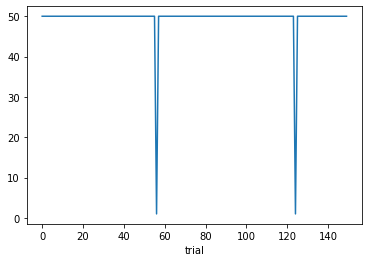

In [15]:
woods1_dfa = parse_metrics(metrics_acs2_explt)

woods1_dfa.set_index('trial', inplace=True)
woods1_dfa['steps_in_trial'].plot()

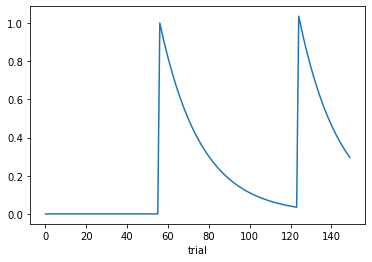

In [16]:
woods1_dfa['rho'].plot()

#### Woods 1 (with binary adapter)

In [17]:
%%time

# m_woods1 = run_experiments(woods1, 24, 8, trials=5000, epsilon=0.9, env_adapter=WoodsAdapter)
m_woods1 = run_experiments(woods1, 8, 8, trials=5000, epsilon=0.9)

INFO:lcs.agents.Agent:{'trial': 0, 'steps_in_trial': 24, 'reward': 1000, 'agent': 'ACS2', 'reliable': 0, 'rho': 0, 'population': 18, 'numerosity': 18}


Starting ACS2 experiments


INFO:lcs.agents.Agent:{'trial': 500, 'steps_in_trial': 13, 'reward': 1000, 'agent': 'ACS2', 'reliable': 231, 'rho': 0, 'population': 1010, 'numerosity': 1873}
INFO:lcs.agents.Agent:{'trial': 1000, 'steps_in_trial': 25, 'reward': 1000, 'agent': 'ACS2', 'reliable': 435, 'rho': 0, 'population': 632, 'numerosity': 2046}
INFO:lcs.agents.Agent:{'trial': 1500, 'steps_in_trial': 25, 'reward': 1000, 'agent': 'ACS2', 'reliable': 345, 'rho': 0, 'population': 483, 'numerosity': 2040}
INFO:lcs.agents.Agent:{'trial': 2000, 'steps_in_trial': 36, 'reward': 1000, 'agent': 'ACS2', 'reliable': 331, 'rho': 0, 'population': 453, 'numerosity': 2006}
INFO:lcs.agents.Agent:{'trial': 2500, 'steps_in_trial': 6, 'reward': 1000, 'agent': 'ACS2', 'reliable': 301, 'rho': 0, 'population': 405, 'numerosity': 2025}
INFO:lcs.agents.Agent:{'trial': 3000, 'steps_in_trial': 6, 'reward': 1000, 'agent': 'ACS2', 'reliable': 290, 'rho': 0, 'population': 382, 'numerosity': 2048}
INFO:lcs.agents.Agent:{'trial': 3500, 'steps_in_

Starting AACS2 experiments


INFO:lcs.agents.Agent:{'trial': 500, 'steps_in_trial': 4, 'reward': 1000, 'agent': 'AACS2', 'reliable': 203, 'rho': 170.17536772062383, 'population': 1038, 'numerosity': 1816}
INFO:lcs.agents.Agent:{'trial': 1000, 'steps_in_trial': 8, 'reward': 1000, 'agent': 'AACS2', 'reliable': 481, 'rho': 301.3972858395415, 'population': 678, 'numerosity': 2037}
INFO:lcs.agents.Agent:{'trial': 1500, 'steps_in_trial': 11, 'reward': 1000, 'agent': 'AACS2', 'reliable': 414, 'rho': 387.4449143579905, 'population': 520, 'numerosity': 2045}
INFO:lcs.agents.Agent:{'trial': 2000, 'steps_in_trial': 15, 'reward': 1000, 'agent': 'AACS2', 'reliable': 367, 'rho': 456.35802948776353, 'population': 467, 'numerosity': 2029}
INFO:lcs.agents.Agent:{'trial': 2500, 'steps_in_trial': 4, 'reward': 1000, 'agent': 'AACS2', 'reliable': 343, 'rho': 494.4901755112639, 'population': 448, 'numerosity': 2039}
INFO:lcs.agents.Agent:{'trial': 3000, 'steps_in_trial': 24, 'reward': 1000, 'agent': 'AACS2', 'reliable': 332, 'rho': 475

Starting ACS2-AR experiments


INFO:lcs.agents.Agent:{'trial': 500, 'steps_in_trial': 8, 'reward': 1000, 'agent': 'ACS2AR', 'reliable': 264, 'rho': 94.12341711363315, 'population': 1032, 'numerosity': 1915}
INFO:lcs.agents.Agent:{'trial': 1000, 'steps_in_trial': 37, 'reward': 1000, 'agent': 'ACS2AR', 'reliable': 479, 'rho': -11.760814743244469, 'population': 646, 'numerosity': 2032}
INFO:lcs.agents.Agent:{'trial': 1500, 'steps_in_trial': 41, 'reward': 1000, 'agent': 'ACS2AR', 'reliable': 397, 'rho': -21.429891388183606, 'population': 515, 'numerosity': 2039}
INFO:lcs.agents.Agent:{'trial': 2000, 'steps_in_trial': 4, 'reward': 1000, 'agent': 'ACS2AR', 'reliable': 349, 'rho': -23.843566415704743, 'population': 448, 'numerosity': 2006}
INFO:lcs.agents.Agent:{'trial': 2500, 'steps_in_trial': 4, 'reward': 1000, 'agent': 'ACS2AR', 'reliable': 317, 'rho': -27.0173353848131, 'population': 399, 'numerosity': 2035}
INFO:lcs.agents.Agent:{'trial': 3000, 'steps_in_trial': 12, 'reward': 1000, 'agent': 'ACS2AR', 'reliable': 305, 

CPU times: user 25min 25s, sys: 14.8 s, total: 25min 40s
Wall time: 29min 33s


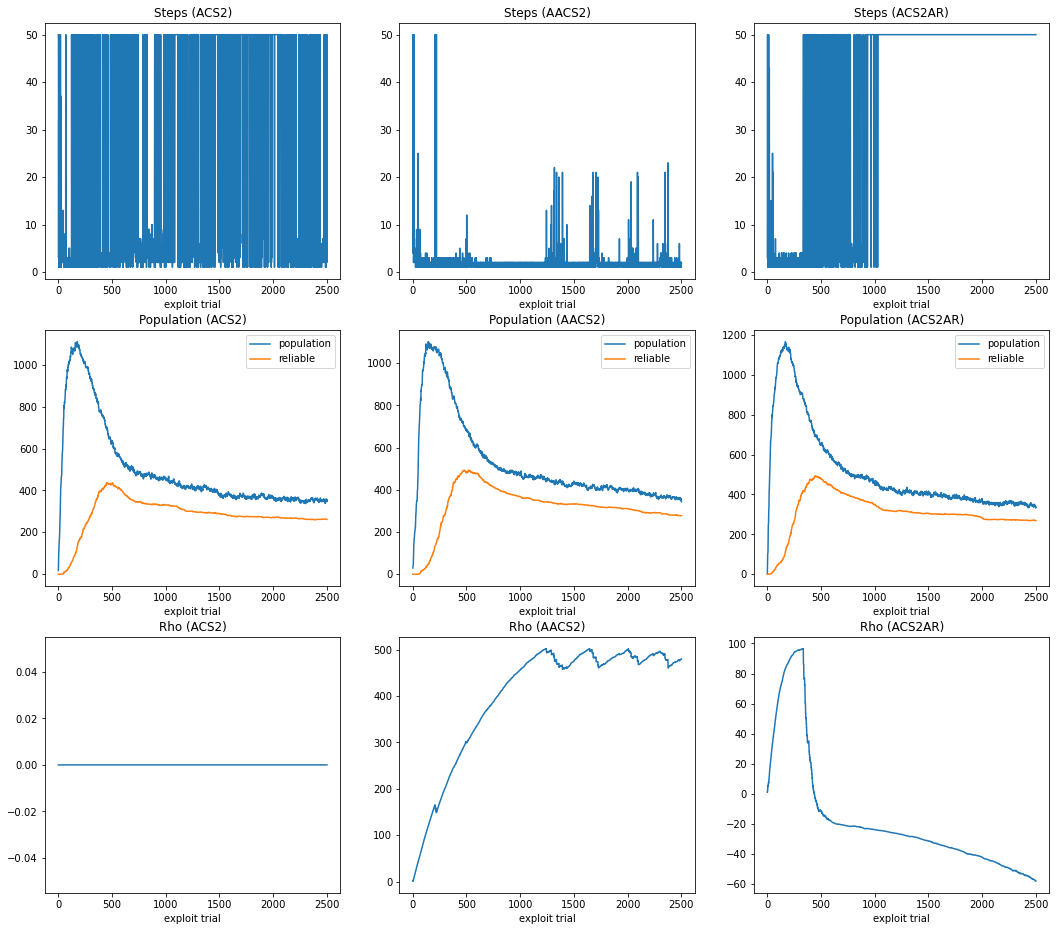

In [19]:
woods1_df = parse_metrics(m_woods1)
plot_exploit_results(woods1_df)

In [24]:
%%time

m_woods1_na = run_experiments(woods1, 8, 8, trials=5000, epsilon=0.9)

INFO:lcs.agents.Agent:{'trial': 0, 'steps_in_trial': 7, 'reward': 1000, 'agent': 'ACS2', 'reliable': 0, 'rho': 0, 'population': 6, 'numerosity': 6}


Starting ACS2 experiments


INFO:lcs.agents.Agent:{'trial': 500, 'steps_in_trial': 2, 'reward': 1000, 'agent': 'ACS2', 'reliable': 224, 'rho': 0, 'population': 742, 'numerosity': 1851}
INFO:lcs.agents.Agent:{'trial': 1000, 'steps_in_trial': 3, 'reward': 1000, 'agent': 'ACS2', 'reliable': 349, 'rho': 0, 'population': 429, 'numerosity': 2066}
INFO:lcs.agents.Agent:{'trial': 1500, 'steps_in_trial': 33, 'reward': 1000, 'agent': 'ACS2', 'reliable': 298, 'rho': 0, 'population': 374, 'numerosity': 2051}
INFO:lcs.agents.Agent:{'trial': 2000, 'steps_in_trial': 16, 'reward': 1000, 'agent': 'ACS2', 'reliable': 290, 'rho': 0, 'population': 378, 'numerosity': 2059}
INFO:lcs.agents.Agent:{'trial': 2500, 'steps_in_trial': 2, 'reward': 1000, 'agent': 'ACS2', 'reliable': 275, 'rho': 0, 'population': 352, 'numerosity': 2042}
INFO:lcs.agents.Agent:{'trial': 3000, 'steps_in_trial': 26, 'reward': 1000, 'agent': 'ACS2', 'reliable': 267, 'rho': 0, 'population': 331, 'numerosity': 2056}
INFO:lcs.agents.Agent:{'trial': 3500, 'steps_in_tr

Starting AACS2 experiments


INFO:lcs.agents.Agent:{'trial': 500, 'steps_in_trial': 8, 'reward': 1000, 'agent': 'AACS2', 'reliable': 211, 'rho': 194.82548608007954, 'population': 749, 'numerosity': 1823}
INFO:lcs.agents.Agent:{'trial': 1000, 'steps_in_trial': 24, 'reward': 1000, 'agent': 'AACS2', 'reliable': 346, 'rho': 306.31099015484324, 'population': 457, 'numerosity': 2051}
INFO:lcs.agents.Agent:{'trial': 1500, 'steps_in_trial': 20, 'reward': 1000, 'agent': 'AACS2', 'reliable': 294, 'rho': 397.74082992239744, 'population': 367, 'numerosity': 2028}
INFO:lcs.agents.Agent:{'trial': 2000, 'steps_in_trial': 9, 'reward': 1000, 'agent': 'AACS2', 'reliable': 277, 'rho': 466.7831320787121, 'population': 357, 'numerosity': 2040}
INFO:lcs.agents.Agent:{'trial': 2500, 'steps_in_trial': 11, 'reward': 1000, 'agent': 'AACS2', 'reliable': 262, 'rho': 501.99768338780194, 'population': 327, 'numerosity': 2045}
INFO:lcs.agents.Agent:{'trial': 3000, 'steps_in_trial': 2, 'reward': 1000, 'agent': 'AACS2', 'reliable': 252, 'rho': 48

Starting ACS2-AR experiments


INFO:lcs.agents.Agent:{'trial': 500, 'steps_in_trial': 9, 'reward': 1000, 'agent': 'ACS2AR', 'reliable': 220, 'rho': 95.1340018193751, 'population': 736, 'numerosity': 1789}
INFO:lcs.agents.Agent:{'trial': 1000, 'steps_in_trial': 17, 'reward': 1000, 'agent': 'ACS2AR', 'reliable': 361, 'rho': 9.730470430396348, 'population': 453, 'numerosity': 2047}
INFO:lcs.agents.Agent:{'trial': 1500, 'steps_in_trial': 50, 'reward': 0, 'agent': 'ACS2AR', 'reliable': 288, 'rho': -20.276038392629737, 'population': 362, 'numerosity': 2052}
INFO:lcs.agents.Agent:{'trial': 2000, 'steps_in_trial': 13, 'reward': 1000, 'agent': 'ACS2AR', 'reliable': 269, 'rho': -24.11222873061816, 'population': 343, 'numerosity': 2039}
INFO:lcs.agents.Agent:{'trial': 2500, 'steps_in_trial': 3, 'reward': 1000, 'agent': 'ACS2AR', 'reliable': 262, 'rho': -28.993086958550542, 'population': 325, 'numerosity': 2061}
INFO:lcs.agents.Agent:{'trial': 3000, 'steps_in_trial': 7, 'reward': 1000, 'agent': 'ACS2AR', 'reliable': 249, 'rho':

CPU times: user 9min 52s, sys: 3.01 s, total: 9min 55s
Wall time: 10min 2s


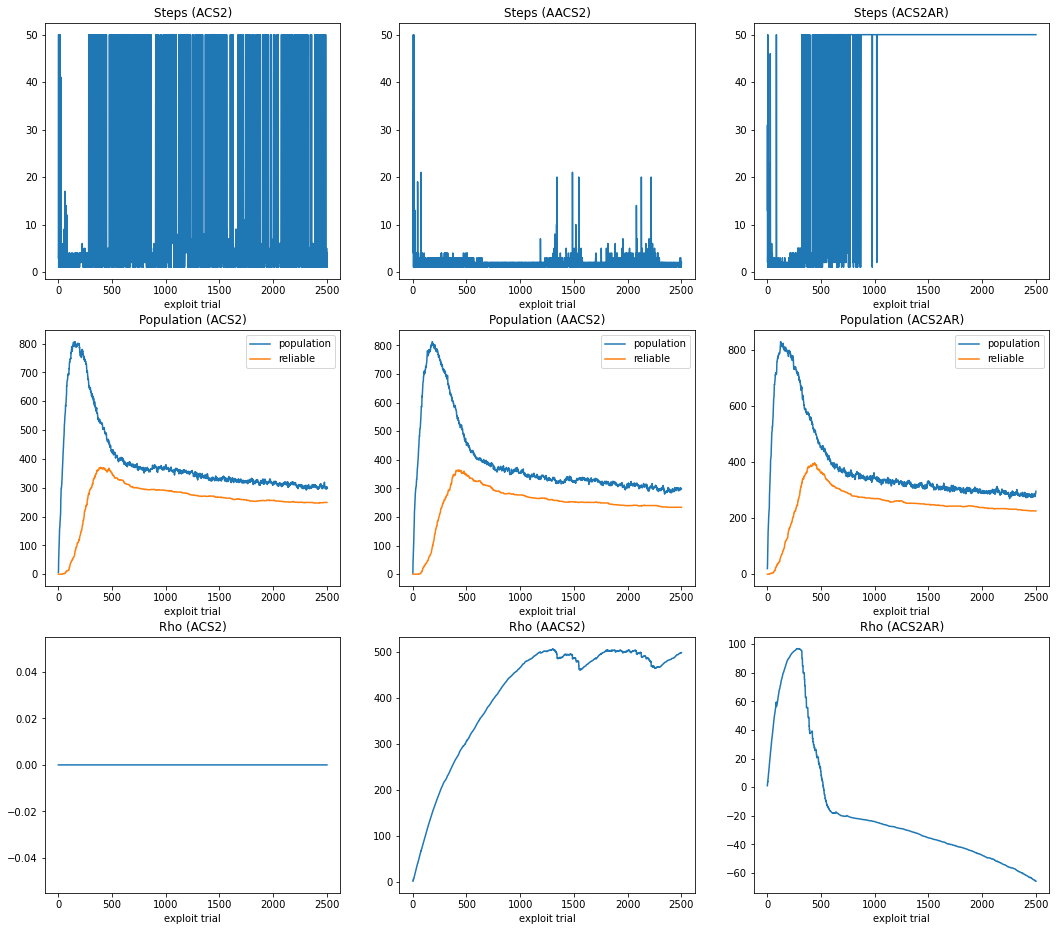

In [25]:
woods1_df_na = parse_metrics(m_woods1_na)
plot_exploit_results(woods1_df_na)

### Woods2

In [ ]:
%%time

m_woods2 = run_experiments(woods2, 24, 8, trials=5000, epsilon=0.9, env_adapter=WoodsAdapter)

In [ ]:
woods2_df = parse_metrics(m_woods2)
plot_exploit_results(woods2_df)

#### Woods 14 (with binary adapter)

In [ ]:
%%time

m_woods14 = run_experiments(woods14, 24, 8, trials=5000, epsilon=0.9, env_adapter=WoodsAdapter)

In [ ]:
woods14_df = parse_metrics(m_woods14)
plot_exploit_results(woods14_df)

### Woods 14 (without binary adapter)

In [ ]:
%%time

m_woods14_wa = run_experiments(woods14, 8, 8, trials=3000, epsilon=0.7)

In [ ]:
woods14_wa_df = parse_metrics(m_woods14_wa)
plot_exploit_results(woods14_wa_df)

#### Discussion
Woods1 and Woods14 are "solvable". The little drawback here is that the `WoodsAdapter` is used transforming perception into 24 bit vector. That causes the population size to grow rapidly which is slowing down the computations. Experiments with more extended alphabets would be useful but then the generalization capabilities will be worse.

### Finite State Worlds (FSW)

#### FSW 10

In [ ]:
%%time

m_fsw10 = run_experiments(fsw10, 1, 2, trials=1000, epsilon=0.9, env_adapter=FSWAdapter)

In [ ]:
fsw10_df = parse_metrics(m_fsw10)
plot_exploit_results(fsw10_df)